In [1]:
import os
import torch
import botorch # library for Bayesian Optimisation research
from torch import nn # Neural Network Module
import pandas as pd
from pyDOE import lhs
import numpy as np
from sklearn.decomposition import PCA
from scipy.interpolate import NearestNDInterpolator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import gpytorch
from botorch.models import SingleTaskGP, FixedNoiseGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood   
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.acquisition import ProbabilityOfImprovement,UpperConfidenceBound,NoisyExpectedImprovement,ExpectedImprovement,qKnowledgeGradient,PosteriorMean
from botorch.optim import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.sampling import manual_seed
from botorch.fit import fit_gpytorch_mll
SMOKE_TEST = os.environ.get("SMOKE_TEST")
device = "cuda" if torch.cuda.is_available() else "cpu" # Get cpu or gpu device for training
print(f'Running on PyTorch {torch.__version__}, Botorch {botorch.__version__}, using {device} device')
torch.set_default_dtype(torch.double)

c:\Users\Utente\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Running on PyTorch 1.13.0+cpu, Botorch 0.8.1, using cpu device


### Problem setup

In [10]:
class TestcaseDataset(Dataset):
    def __init__(self):
        # data loading
        df = pd.read_csv('Case3_finer.csv')
        X_data  = np.vstack([df["alpha0"].to_numpy() ,
                             df["alpha1"].to_numpy() ,
                             df["alpha2"].to_numpy() ,
                             df["alpha3"].to_numpy() ])
        Cx_data = df['SumCx'].to_numpy() 
        Cx_data = StandardScaler().fit_transform(Cx_data.reshape(-1,1))
        self.pts_original = X_data.T.copy()
        self.pts_original = StandardScaler().fit_transform(self.pts_original)
        # compute PCA 
        pca = PCA(n_components=4, svd_solver='full').fit(self.pts_original)
        self.pts_transformed = pca.transform(self.pts_original)
        #self.pts_transformed = self.pts_original

        # Sample RSMs
        dim = 4
        N = 10000
        lb = np.min(self.pts_transformed,axis=0)
        ub = np.max(self.pts_transformed,axis=0)
        bounds = {'lb': lb, 'ub': ub}
        self.pts = lb + (ub - lb) * lhs(dim, N) # generate latin-hypercube
        # But Pts are not in convex hull of pts_transformed (LD interpolator does not extrapolate) 
        r =  NearestNDInterpolator(self.pts_transformed, Cx_data)
        # pts has be inside region of interpolation .
        valuesTrasf = r(self.pts) 
        data = np.vstack([self.pts.T,valuesTrasf.reshape(-1,1).T]).T

        hifi, lofi = train_test_split(data, test_size=1e-3, shuffle=True)
        hifi, test = train_test_split(hifi, test_size=1e-1)

        # Cast them
        self.X_hifi = torch.Tensor(hifi[:,:-1]) 
        self.X_lofi = torch.Tensor(lofi[:,:-1]) 
        self.X_test = torch.Tensor(test[:,:-1]) 
        self.Y_hifi = torch.Tensor(hifi[:,-1] ).unsqueeze(-1)
        self.Y_lofi = torch.Tensor(lofi[:,-1] ).unsqueeze(-1)
        self.Y_test = torch.Tensor(test[:,-1] ).unsqueeze(-1)

        self.hifi_dataset = TensorDataset(self.X_hifi, self.Y_hifi)
        self.test_dataset = TensorDataset(self.X_test, self.Y_test)
    def __call__(self):
        return self.hifi_dataset, self.test_dataset, self.pts_transformed, self.pts, self.X_hifi, self.X_lofi, self.X_test, self.Y_hifi, self.Y_lofi, self.Y_test, self.pts_original

Shape of low fidelity  X and y:  torch.Size([10, 4]) torch.Size([10, 1])
Shape of high fidelity X and y:  torch.Size([8991, 4]) torch.Size([8991, 1])
Shape of test set      X and y:  torch.Size([999, 4]) torch.Size([999, 1])
Buonds shape:  torch.Size([2, 4])


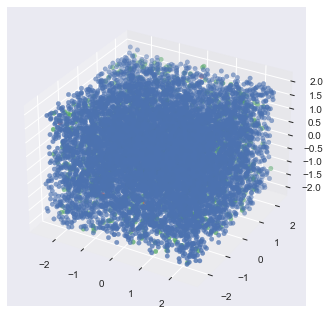

pts shape (10000, 4)


In [11]:
dataset = TestcaseDataset()
pts = dataset.pts # total samples ( train + test )
X_lofi = dataset.X_lofi
Y_lofi = dataset.Y_lofi
X_hifi = dataset.X_hifi
Y_hifi = dataset.Y_hifi
X_test = dataset.X_test
Y_test = dataset.Y_test
hifi_dataset = dataset.hifi_dataset
test_dataset = dataset.test_dataset

print("Shape of low fidelity  X and y: ",X_lofi.shape, Y_lofi.shape)
print("Shape of high fidelity X and y: ",X_hifi.shape, Y_hifi.shape)
print("Shape of test set      X and y: ",X_test.shape, Y_test.shape)
bounds = torch.Tensor([[pts[:,0].min(), pts[:,1].min(), pts[:,2].min(), pts[:,3].min()], [pts[:,0].max(), pts[:,1].max(), pts[:,2].max(), pts[:,3].max()]])
print("Buonds shape: ", bounds.shape)

# Create data loaders
hifi_dataloader = DataLoader(hifi_dataset, batch_size = 32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle=True)
best_obs_value = Y_hifi.numpy().max()

noise_level = 1e-1
noise = noise_level*torch.ones(X_lofi.shape[0])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_hifi[:, 0],X_hifi[:, 1],X_hifi[:, 2])
ax.scatter(X_test[:, 0],X_test[:, 1],X_test[:, 2])
ax.scatter(X_lofi[:, 0],X_lofi[:, 1],X_lofi[:, 2])
plt.show()
print('pts shape',pts.shape)

### High Fidelity Model initilization

In [12]:
# Define hyperparameters
n_samples, n_features = X_hifi.shape
input_size = n_features
hidden_size = 128
output_size = 1
learning_rate = 1e-2
# Define the neural network model (input, hidden, output size)
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(NeuralNet, self).__init__()
        # Define layers
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.LeakyReLU() # activation function nn.LeakyReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        #out = self.sigmoid(out)
        return out

In [13]:
nn_model = NeuralNet(input_size,hidden_size,output_size).to(device)
print(nn_model)

# Construct loss and optmizer 
criterion = nn.MSELoss() # Mean Square Error Loss # loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate) # from the optimization module

# In a single training epoch, the model makes predictions on the training dataset (fed to it in batches)
# and backpropagates the prediction error to update the model’s parameters

# Training loop:
#  - forward pass: compute predictions
#  - backward pass: gradients
#  - update weights
num_epochs = 500 if not SMOKE_TEST else 5 # epoch -> forward and backward of ALL training samples
for epoch in range(num_epochs):
    size = len(hifi_dataloader.dataset)
    nn_model.train()
    for batch, (X, y) in enumerate(hifi_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = nn_model(X)         # prediction: forward pass
        loss = criterion(pred, y) # loss

        # Backpropagation
        optimizer.zero_grad()   # clears old gradients from the last step
        loss.backward()         # gradients: backward pass
        optimizer.step()        # update weights

    if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} / {num_epochs}, step [{batch+1}/{len(hifi_dataloader)}] loss: {loss:.4f}")
# Test       
size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
test_loss, correct, num_samples = 0, 0, 0
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = nn_model(X)
        test_loss += criterion(pred, y).item()
        num_samples += y.shape[0]
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
acc = 100.0 * correct / num_samples
print(f"Test Error -> Test loss: {test_loss:>8f} \n") # Acc: {acc:>8f}

def pred(new_point, model):
    with torch.no_grad():
            pred_point = model(new_point)
    return pred_point

NeuralNet(
  (linear1): Linear(in_features=4, out_features=128, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 10 / 500, step [281/281] loss: 0.0302
Epoch 20 / 500, step [281/281] loss: 0.2855
Epoch 30 / 500, step [281/281] loss: 0.2353
Epoch 40 / 500, step [281/281] loss: 0.1740
Epoch 50 / 500, step [281/281] loss: 0.0963
Epoch 60 / 500, step [281/281] loss: 0.2372
Epoch 70 / 500, step [281/281] loss: 0.1519
Epoch 80 / 500, step [281/281] loss: 0.1231
Epoch 90 / 500, step [281/281] loss: 0.0795
Epoch 100 / 500, step [281/281] loss: 0.0901
Epoch 110 / 500, step [281/281] loss: 0.2826
Epoch 120 / 500, step [281/281] loss: 0.1062
Epoch 130 / 500, step [281/281] loss: 0.1083
Epoch 140 / 500, step [281/281] loss: 0.1926
Epoch 150 / 500, step [281/281] loss: 0.0687
Epoch 160 / 500, step [281/281] loss: 0.0901
Epoch 170 / 500, step [281/281] loss: 0.0887
Epoch 180 / 500, step [281/281] loss: 0

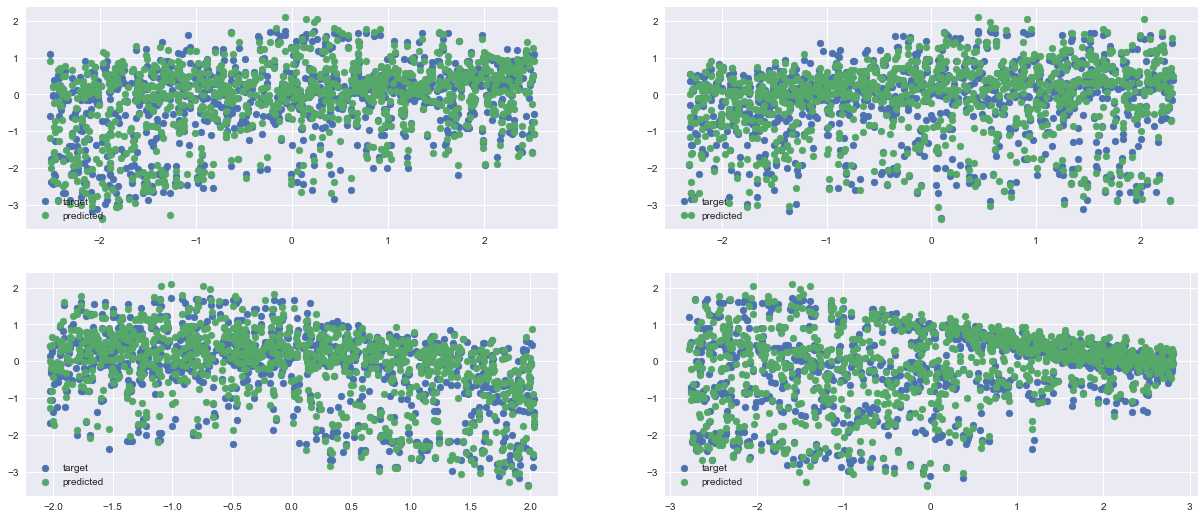

In [14]:
fig = plt.figure(figsize=(21, 9))
Y_pred = pred(X_test, nn_model)
for alpha in range(4):
    
    ax = fig.add_subplot(2, 2, alpha+1)
    ax.scatter(X_test[:,alpha].numpy(), Y_test.numpy(),label = 'target')
    ax.scatter(X_test[:,alpha].numpy(), Y_pred.numpy(),label = 'predicted')
    plt.legend()
plt.show()

### Surrogate Model Initialization

In [15]:
def initialize_model(X_lofi, Y_lofi, noise):
  X_lofi, Y_lofi = X_lofi.to(device), Y_lofi.to(device)
  likelihood = gpytorch.likelihoods.GaussianLikelihood(noise=noise, learn_additional_noise=False)
  single_model = SingleTaskGP(X_lofi, Y_lofi)
  #single_model = ExactGPModel(X_lofi.squeeze(), Y_lofi.squeeze(), likelihood)
  
  mll = ExactMarginalLogLikelihood(likelihood, single_model) # OTHER LIKELIHOOD ?
  return mll, single_model

Define a helper function that performs the essential BO step

In [16]:
def get_next_points(single_model, n_points=1, acqf_name="qNEI"):

  NUM_RESTARTS = 10 if not SMOKE_TEST else 2
  RAW_SAMPLES = 512 if not SMOKE_TEST else 4
  NUM_FANTASIES = 128 if not SMOKE_TEST else 4

  sampler = SobolQMCNormalSampler(512)

  if acqf_name == "qNEI":
    acqf_name  = qNoisyExpectedImprovement(model = single_model, X_baseline = X_lofi, sampler=sampler )
  elif acqf_name == "qKG" :
    acqf_name  = qKnowledgeGradient(model = single_model, num_fantasies=NUM_FANTASIES)
  elif acqf_name == "EI":
    acqf_name  = ExpectedImprovement( model = single_model, best_f = best_obs_value )
  elif acqf_name == "qEI":
    acqf_name  = qExpectedImprovement( model = single_model, best_f = best_obs_value, sampler=sampler )
  elif acqf_name == "PI":
    acqf_name  = ProbabilityOfImprovement( model = single_model, best_f = best_obs_value )
  elif acqf_name == "UCB":
    acqf_name  = UpperConfidenceBound(model = single_model, beta=0.3)
  elif acqf_name == "qKG_proper" :
    qKG  = qKnowledgeGradient(model = single_model, num_fantasies=NUM_FANTASIES)
    argmax_pmean, max_pmean = optimize_acqf(
      acq_function=PosteriorMean(single_model), 
      bounds=bounds,
      q=1,
      num_restarts=10 if not SMOKE_TEST else 2,
      raw_samples=1024 if not SMOKE_TEST else 4,
    )
    acqf_name = qKnowledgeGradient(
      single_model,
      num_fantasies=NUM_FANTASIES,
      sampler=qKG.sampler,
      current_value=max_pmean,
    )
  else:
    raise RuntimeError("Unknown acquisition function name!")
 
  with manual_seed(1234):
    candidates, acq_value = optimize_acqf(
        acq_function=acqf_name, 
        bounds=bounds,
        q=n_points,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES
    )
  return candidates

In [17]:
best_obs_value

1.7825763360501887

### Perform a few steps of multi-fidelity BO

In [27]:
N_ITER = 3 if not SMOKE_TEST else 1
X_lofi = X_lofi[0:10]
Y_lofi = Y_lofi[0:10]
for iter in range(N_ITER):
   mll, gp_model = initialize_model(X_lofi, Y_lofi, noise)
   fit_gpytorch_mll(mll)
   new_X = get_next_points(gp_model, n_points=8)  
   predicted_optimal_obj = pred(new_X, nn_model) 
   print(f"Iter {iter+1}/{N_ITER} - next points: {new_X}\n pred objectives: {predicted_optimal_obj}")
   X_lofi = torch.cat([X_lofi, new_X ])
   Y_lofi = torch.cat([Y_lofi, predicted_optimal_obj])
   best_obs_value = max(best_obs_value,Y_lofi.max())
   noise  = torch.cat([noise, 1e-3*torch.ones(new_X.shape[0]) ])

Iter 1/3 - next points: tensor([[ 0.5238,  0.0794, -0.6667,  0.3073],
        [-0.8412, -0.1214, -0.8642, -2.1391],
        [-1.5001,  1.8571,  0.3005,  0.8963],
        [ 1.8662, -0.8710,  0.4080,  1.8565],
        [-0.6760, -0.0739, -0.3377, -1.7641],
        [ 1.8149, -0.7817,  0.8452,  1.9371],
        [ 0.1014, -2.1741, -2.0360,  0.3489],
        [-0.3952, -0.2054, -0.2608, -2.2201]])
 pred objectives: tensor([[ 0.7818],
        [ 1.7149],
        [ 0.9847],
        [ 0.3484],
        [ 1.3751],
        [ 0.5043],
        [-0.6314],
        [ 0.7265]])
Iter 2/3 - next points: tensor([[-0.2385, -0.0175, -0.5868, -1.8797],
        [-0.7036,  0.1708, -0.7963, -2.1825],
        [-0.7615, -0.3589, -0.5159, -1.6957],
        [-0.7787, -0.0379,  0.0464, -2.1840],
        [-0.7277, -0.0169, -0.9287, -1.4235],
        [ 2.5217, -2.3138,  0.0859, -2.8024],
        [-1.0311, -0.2903, -0.5546, -2.5573],
        [-1.8524,  1.7594,  0.3178,  0.6633]])
 pred objectives: tensor([[ 1.6005],
      

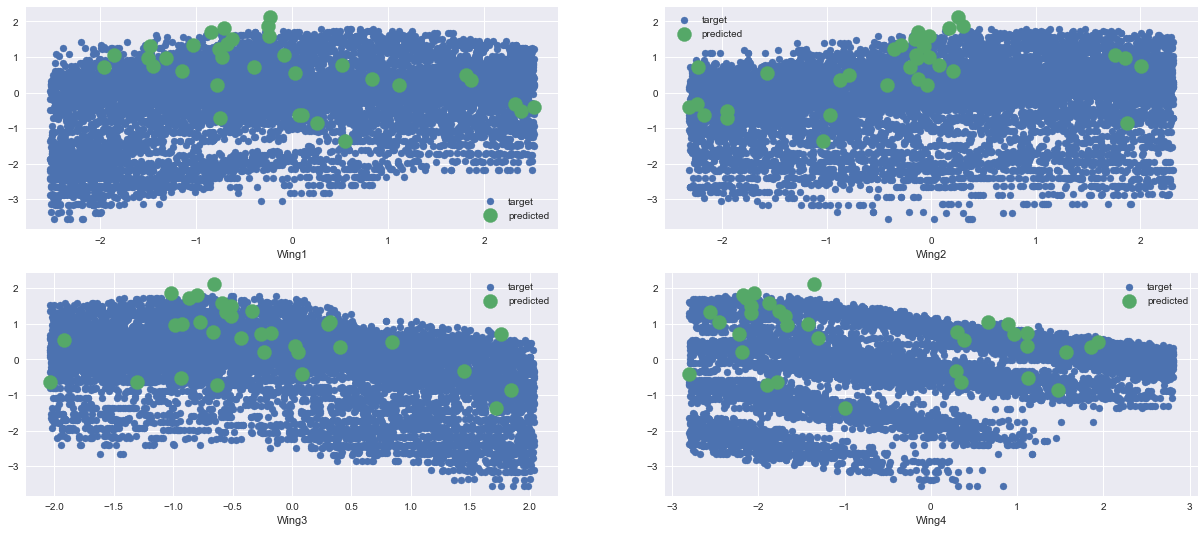

In [28]:
fig = plt.figure(figsize=(21, 9))
for alpha in range(4):
    ax = fig.add_subplot(2, 2, alpha+1)
    ax.scatter(X_hifi[:,alpha].numpy(), Y_hifi.numpy(),label = 'target')
    ax.scatter(X_lofi[:,alpha].numpy(), Y_lofi.numpy(),s=200,label = 'predicted')
    plt.legend()
    plt.xlabel(f"Wing{alpha+1}")
plt.show()

In [29]:
# Define the Kernel of Gaussian Process
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self,X_train, Y_train,likelihood):
        super(ExactGPModel, self).__init__(X_train, Y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

Wing1 - Iter 100/1000 - Loss: 1.25971 LenghtParam 0.63934
Wing1 - Iter 200/1000 - Loss: 1.24646 LenghtParam 0.57883
Wing1 - Iter 300/1000 - Loss: 1.23379 LenghtParam 0.51967
Wing1 - Iter 400/1000 - Loss: 1.22238 LenghtParam 0.46620
Wing1 - Iter 500/1000 - Loss: 1.21320 LenghtParam 0.42105
Wing1 - Iter 600/1000 - Loss: 1.20679 LenghtParam 0.38526
Wing1 - Iter 700/1000 - Loss: 1.20289 LenghtParam 0.35832
Wing1 - Iter 800/1000 - Loss: 1.20076 LenghtParam 0.33879
Wing1 - Iter 900/1000 - Loss: 1.19968 LenghtParam 0.32501
Wing1 - Iter 1000/1000 - Loss: 1.19915 LenghtParam 0.31548


Wing2 - Iter 100/1000 - Loss: 1.13214 LenghtParam 0.74200
Wing2 - Iter 200/1000 - Loss: 1.11479 LenghtParam 0.78746
Wing2 - Iter 300/1000 - Loss: 1.10103 LenghtParam 0.82688
Wing2 - Iter 400/1000 - Loss: 1.09050 LenghtParam 0.85827
Wing2 - Iter 500/1000 - Loss: 1.08268 LenghtParam 0.88065
Wing2 - Iter 600/1000 - Loss: 1.07700 LenghtParam 0.89472
Wing2 - Iter 700/1000 - Loss: 1.07300 LenghtParam 0.90268
Wing2 - Ite

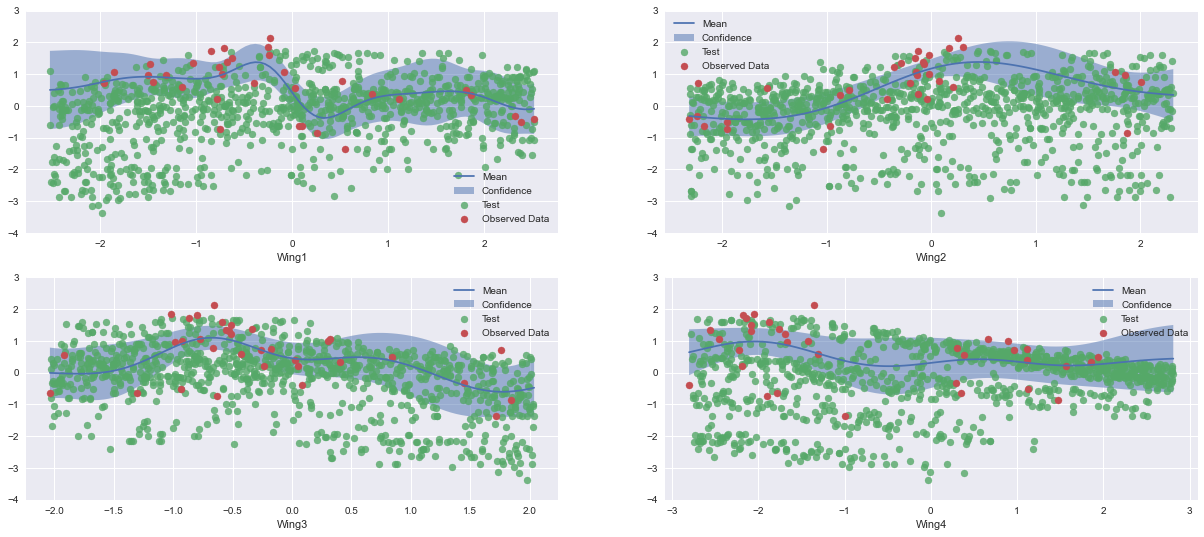

In [30]:
fig = plt.figure(figsize=(21, 9))
for alpha in range(4):
# FIT THE MODEL
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    # Define the model
    #gp_model = SingleTaskGP(X_lofi[2:,alpha].unsqueeze(-1) , Y_lofi[2:], likelihood = likelihood  )
    gp_model = ExactGPModel(X_lofi[2:,alpha] , Y_lofi[2:].squeeze(), likelihood)
    # Find optimal model hyperparameters
    gp_model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(gp_model.parameters(),lr=1e-3) # Use the adam optimizer  # Includes GaussianLikelihood parameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model) # "Loss" for GPs - the marginal log likelihood
    #mll = gpytorch.mlls.LeaveOneOutPseudoLikelihood(likelihood, gp_model) # "Loss" for GPs - LOO Pseudo likelihood

    training_iter  = 1000 if not SMOKE_TEST else 4
    for i in range(training_iter):
        optimizer.zero_grad()    # Zero gradients from previous iteration
        output = gp_model(X_lofi[2:,alpha])        # Output from model
        loss = -mll(output, Y_lofi[2:].squeeze())     # compute loss and backprop gradients
        loss.backward()
        if (i+1) % 100 == 0:
            print(f'Wing{alpha+1} - Iter {i + 1}/{training_iter} - Loss: {loss.item():.5f} LenghtParam {gp_model.covar_module.base_kernel.lengthscale.detach().numpy()[0,0]:.5f}')
        optimizer.step()
    print('\n')
    
    gp_model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(X_hifi[:,alpha].min(), X_hifi[:,alpha].max(), 100)
        observed_pred = (gp_model(test_x ))      # Make predictions by feeding model through likelihood
        ax = fig.add_subplot(2, 2, alpha+1)      # Initialize plot
        lower, upper = observed_pred.confidence_region()     # Get upper and lower confidence bounds
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), label = 'Mean')     # Plot predictive means as blue line
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence')  # Shade between the lower and upper confidence bounds
        ax.scatter(X_test[:,alpha].numpy(), Y_test.numpy(), alpha=0.8, label = 'Test')
        ax.scatter(X_lofi[:,alpha].numpy(), Y_lofi.numpy(), s=50,label = 'Observed Data')
        ax.set_ylim([-4,3])
        plt.xlabel(f"Wing{alpha+1}")
        ax.legend()
    # DECREASE VARIANCE
plt.show()